In [ ]:
"""
Simple EDA and simple logistic regression model
1. Using one feature: roc_auc_score = 0.68

2. Using two features
    - roc_auc_score = 0.683
    - explore threshold values (0.139 for high recall)
    - examin F1 score, log loss

"""

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')

In [53]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,25.0,50-99,unknown,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,5,47,0
2,11561,city_21,0.624,unknown,No relevent experience,Full time course,Graduate,STEM,5.0,50-99,unknown,0,83,0
3,33241,city_115,0.789,unknown,No relevent experience,unknown,Graduate,Business Degree,0.5,50-99,Pvt Ltd,0,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,25.0,50-99,Funded Startup,4,8,0


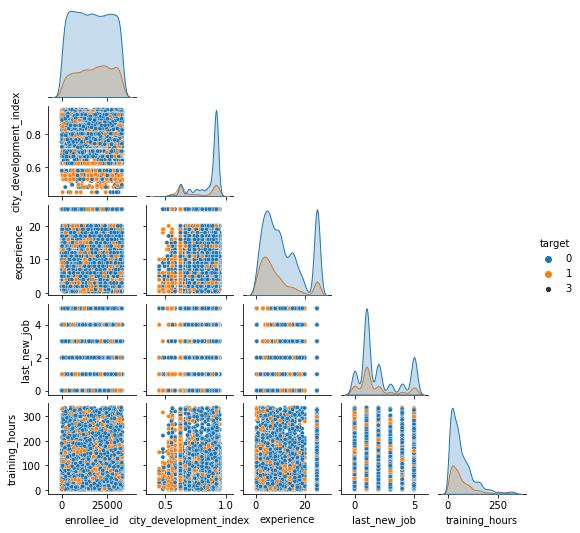

In [14]:
# Pairplot
sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='target');

### 2. Using only one featue: 'city_development_index'

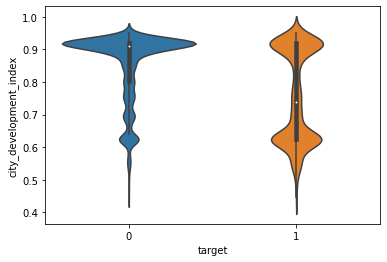

In [66]:
# Separabitiliy
sns.violinplot(y =df_train['city_development_index'],
              x=df_train['target']);

In [67]:
from sklearn.linear_model import LogisticRegression
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['city_development_index']], df_train['target'])
print('intercept: ', round(lm_1.intercept_[0], 4))
print('city_development_index coef: ', round(lm_1.coef_[0][0], 4))

intercept:  3.7388
city_development_index coef:  -5.9869


In [105]:
lm_1.predict_proba(df_test[['city_development_index']])

array([[0.77071706, 0.22928294],
       [0.85435165, 0.14564835],
       [0.49925516, 0.50074484],
       ...,
       [0.82800866, 0.17199134],
       [0.74548315, 0.25451685],
       [0.74548315, 0.25451685]])

In [68]:
df_eval = df_test.copy()
df_eval['pred'] = lm_1.predict(df_test[['city_development_index']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['target']

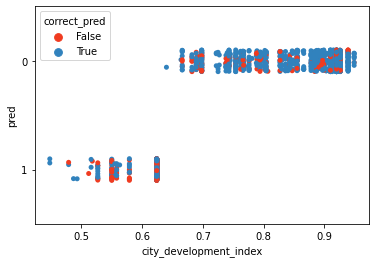

In [69]:
sns.stripplot(data=df_eval,
              x='city_development_index',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [70]:
lm_1.predict_proba(df_test[['city_development_index']])[:5]

array([[0.77071706, 0.22928294],
       [0.85435165, 0.14564835],
       [0.49925516, 0.50074484],
       [0.77071706, 0.22928294],
       [0.85435165, 0.14564835]])

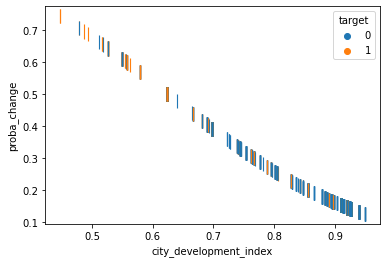

In [71]:
df_eval['proba_change'] = lm_1.predict_proba(df_eval[['city_development_index']])[:, 1]
sns.scatterplot(data=df_eval,
                x='city_development_index',
                y='proba_change',
                hue='target',
                marker='|',
                s=200);

#### Check Error

In [72]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

In [78]:
pd.DataFrame(confusion_matrix(df_eval['target'], df_eval['pred']),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1406,147
Changing (1),322,254


In [79]:
fpr, tpr, thresholds = roc_curve(df_eval['target'],
                                 df_eval['proba_change'])

In [80]:
# ROC: Receiver Operating Characteristic
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

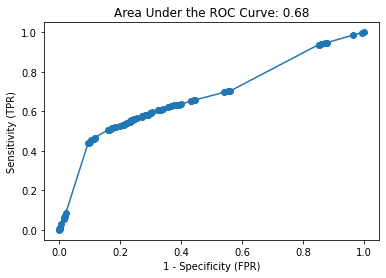

In [81]:
plot_roc(df_eval['target'], df_eval['proba_change'])

In [87]:
# If we want to find all the 'Looking for change' (prioritize TPR)
mask = tpr > 0.9
thresholds[mask].max()

0.14564835342606733

In [ ]:
# then we need to pick all the rows with probability > 0.146

### 3. Multiple Logistic Regression

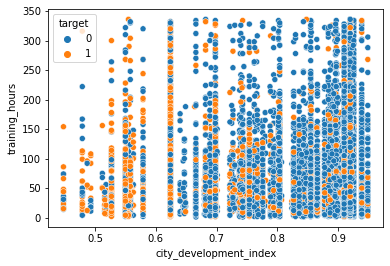

In [88]:
sns.scatterplot(data=df_train,
                x='city_development_index',
                y='training_hours',
                hue='target');

In [148]:
features = ['city_development_index', 'training_hours']

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train = scaler.fit_transform(df_train[features])
y_train = df_train['target']

In [149]:
lm_2 = LogisticRegression()
lm_2.fit(X_train, y_train)
X_test = scaler.transform(df_test[features])
y_test = df_test['target']
preds = lm_2.predict(X_test)

In [150]:
# Threshold = 0.5
pd.DataFrame(confusion_matrix(df_test['target'], preds),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),1438,115
Changing (1),399,177


In [223]:
roc_auc_score(y_test,preds)

0.6166207206482078

In [152]:
# Improved!

In [153]:
# Cross-validation
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(lm_2,X_test, y_test, cv=5, scoring='roc_auc')
print('Scores:', cv_scores)
print('Mean:', np.mean(cv_scores))

Scores: [0.72155172 0.67877814 0.6849993  0.6623235  0.65242637]
Mean: 0.680015805653858


#### Explore different threshold values

In [154]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Not Looking', 'Looking'],
           yticklabels=['Not Looking', 'Looking']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [155]:
# Let's see how our confusion matrix changes with changes to the cutoff! 

from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm_2, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [174]:
df_test['proba_change'] = lm_2.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test,
                                 df_test['proba_sf'])

##### * Plot ROC curve

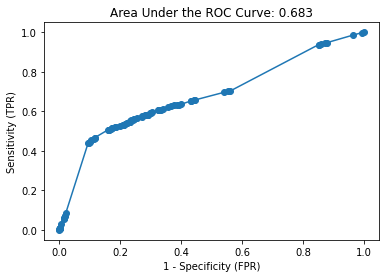

In [161]:
plot_roc(df_test['target'], lm_2.predict_proba(X_test)[:, 1])

In [179]:
# Want high recall (lower threshold)
# in order to catch everyone who's looking for a change
mask = tpr > 0.95
thresholds[mask].max()

0.1390380482278954

In [181]:
preds_low_th = (lm_2.predict_proba(X_test)[:, 1] >= 0.139)

# Threshold = 0.146
pd.DataFrame(confusion_matrix(df_test['target'], preds_low_th),\
             columns=['Predict-not changing (0)','Predict-change (1)'],\
            index=['Not changing (0)','Changing (1)'])

,Predict-not changing (0),Predict-change (1)
Not changing (0),163,1390
Changing (1),28,548


##### * Plot precision, recall curve

In [207]:
# Precision, recall curve
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, lm_2.predict_proba(X_test)[:,1])

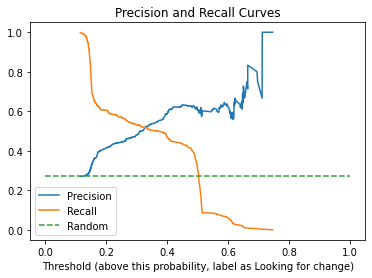

In [216]:
plt.plot(thresholds, precision[1:],label='Precision')
plt.plot(thresholds, recall[1:],label='Recall');

# Plot random guess precision, recall currve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')

plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Looking for change)');
plt.title('Precision and Recall Curves');

##### * Plot recall-precision curve

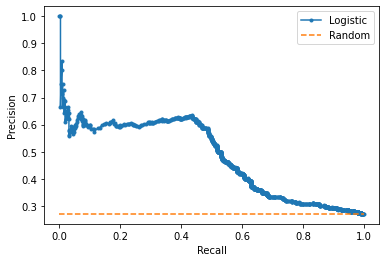

In [211]:
plt.plot(recall, precision, marker='.', label='Logistic')

# Plot random guess precision, recall currve
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='Random')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend();

### 4. Compare Scores

* ROC AUC score

In [219]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

In [220]:
# Threshold = 0.5
y_predict = lm_2.predict(X_test)
f1_score(y_test, y_predict)

0.40783410138248855

In [222]:
# Threshold = 0.139
y_predict = (lm_2.predict_proba(X_test)[:, 1] > 0.139)
f1_score(y_test, y_predict)

0.43595863166268894

* F1 score

In [228]:
# Threshold = 0.5
y_predict = lm_2.predict(X_test)
roc_auc_score(y_test, y_predict)

0.6166207206482078

In [229]:
# Threshold = 0.139
y_predict = (lm_2.predict_proba(X_test)[:, 1] > 0.139)
roc_auc_score(y_test, y_predict)

0.5281735172068398

* Log loss cross-entropy

In [234]:
from sklearn.metrics import log_loss

print("Log-loss on logit: {:6.4f}".format(log_loss(y_test, lm_2.predict_proba(X_test))))

Log-loss on logit: 0.5272


In [235]:
# Threshold = 0.5
y_predict = lm_2.predict_proba(X_test)
log_loss(y_test, y_predict)

0.5272252353146047

In [232]:
# Threshold = 0.139
y_predict = (lm_2.predict_proba(X_test)[:, 1] > 0.139)
log_loss(y_test, y_predict)

23.004742305500855